# Start
In this simple tutorial we are going to call a pre-existing QNN model composed by a feature map circuit together with an ansatz circuit and we are going to evaluate its generalization performance on the Mnist dataset composed by the {0,1} digits. People interested to expand the script are encouraged to improve it! 😊 

### Import needed libraries and much more...

In [5]:
import qiskit
import os
import tensorflow as tf
from tensorflow import keras
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, transpile
from qiskit import BasicAer, Aer, execute
from qiskit.visualization import *
from qiskit.quantum_info.operators import Operator
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.parameter import Parameter
import qiskit
from qiskit.visualization import *
from qiskit.circuit.parameter import Parameter
from qiskit_machine_learning.neural_networks import CircuitQNN, SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.utils import QuantumInstance
from torch.nn import CrossEntropyLoss
from torch.optim import LBFGS
from qiskit.utils import QuantumInstance
from torch import Tensor
from Qnn_class import QNN
from dataset import data_mnist, Galaxy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support
import pandas as pd

# Set a seed and connect to the simulator
seed = 42
qi = QuantumInstance(Aer.get_backend('aer_simulator'), seed_simulator=seed,seed_transpiler=seed,shots=4)
qi.backend.set_option("seed_simulator", seed)

/var/folders/lx/p5pprllx5m17px64p45s4cpr0000gn/T/ipykernel_81544/653594547.py:29: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qi = QuantumInstance(Aer.get_backend('aer_simulator'), seed_simulator=seed,seed_transpiler=seed,shots=4)


Have a look to the functions I'm going to import below ⬇️ 

In [96]:
from circuits import *
from Qnn_class import QNN

In [46]:
device = "rlrl" ## choose the circuits that will compose the QNN model. To see the other options, please go 
# to the circuits file and scroll the possibile circuits. If u want to make your own circuit, 
# please do it!

### Metrics
Define some metrics and store the result inside the "tutorial" folder you should create at the beginning.

In [102]:
def confusion_m_training(true_labels, y_predicted, num_train, nrun):
    cm = confusion_matrix(true_labels, y_predicted)
    prfs = precision_recall_fscore_support(true_labels, y_predicted)
    print("Precision, recall, f_score, support:", prfs)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("/Users/francescoaldoventurelli/Desktop/tutorial/cm_train"+str(num_train)+"_run"+str(nrun+1)+".jpg",dpi=900)
    plt.close()
    return disp

def confusion_m_testing(true_labels, y_predicted, num_train, nrun):
    cm = confusion_matrix(true_labels, y_predicted)
    prfs = precision_recall_fscore_support(true_labels, y_predicted)
    print("Precision, recall, f_score, support:", prfs)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.savefig("/Users/francescoaldoventurelli/Desktop/tutorial/cm_test"+str(num_train)+"_"+str(nrun+1)+".jpg",dpi=900)
    plt.close()
    return disp

In [9]:
def train_plot(x_train, y_train):
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16, 16))
    fig.suptitle("Train set")

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(x_train[i].reshape((16,16)), cmap="gray")
        ax.set_xlabel(y_train[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    #save = plt.savefig("/Users/francescoaldoventurelli/Desktop/TESI_FINAL/train/train"+str(num_train)+"_dist_run_WF_2L"+str(nrun+1)+".jpg")
    #plt.close()
    return fig

In [47]:
qubits = 6 # set the number of qubits you are going to use in the ciruits
features=[] ### features
for i in range(256):
    features.append(Parameter('θ'+str(i)))
for i in range(8):
    features.append(np.pi/2) # we guess 8 initial features because we use a circuit composed by 6 qubits,
    # 2 unitary gates applied to each qubit and repeated for 22 layers -> 6x2x22 = 264 - 256 = 8.
    # As you can see above, we would have 264 features in total, but our images have only 8 less, so we 
    # initialize them as we want.

nlayers_featuremap = 22
nlayers_ansatz = 3
param_y=[]  ### learnable paramteres i.e. weights
for i in range(qubits*2*nlayers_ansatz):
    param_y.append(Parameter('y'+str(i))) # we initialize the weights the ansatz is going to learn during the training


In [104]:
# Build the model by calling the method contained in the Qnn_class file
qnn_model = QNN(shots=256,features=features,learning_weights=param_y,model_nam=device, nqubits=qubits,
                nlayers_featuremap=nlayers_featuremap, nlayers_ansatz=nlayers_ansatz)

qnn_model.make_qc()
fm = qnn_model.feature_map()
ans = qnn_model.ansatz()
model = qnn_model.model()

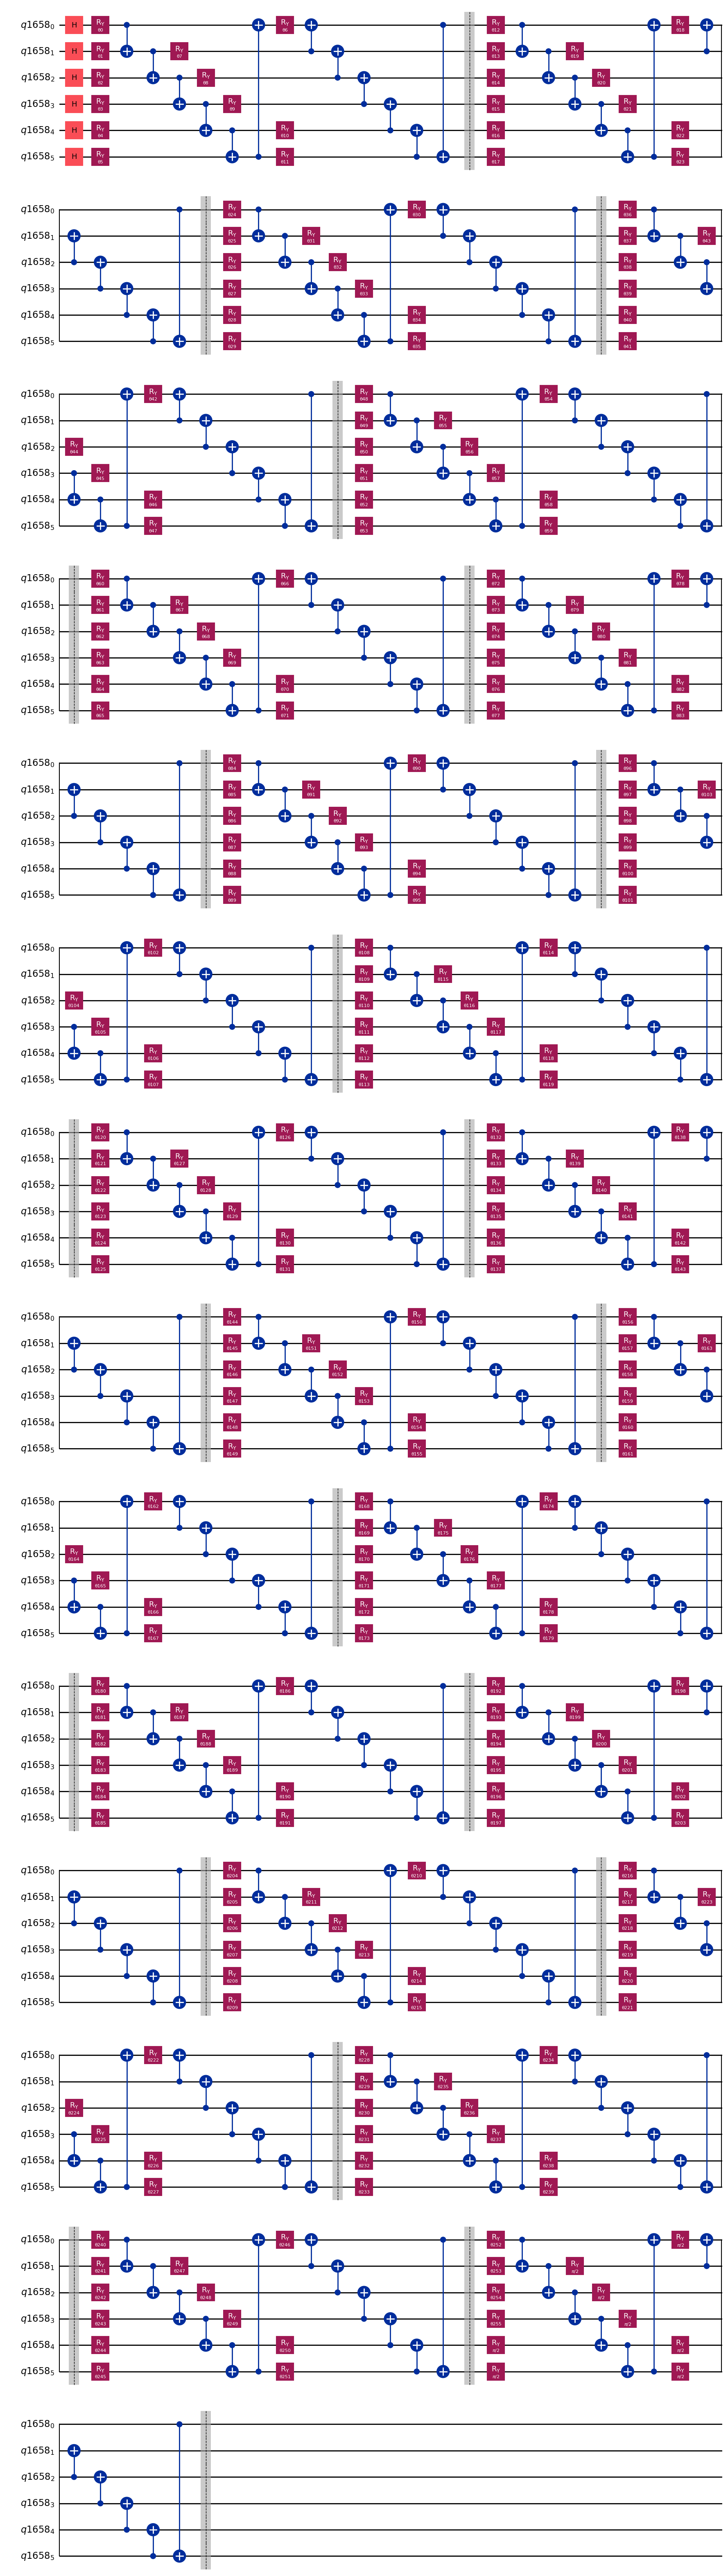

In [105]:
fm.draw('mpl', style='iqx')
#plt.savefig(path_2_save+'tutorial'+'/feature_map.jpeg',dpi=800)
#plt.show()

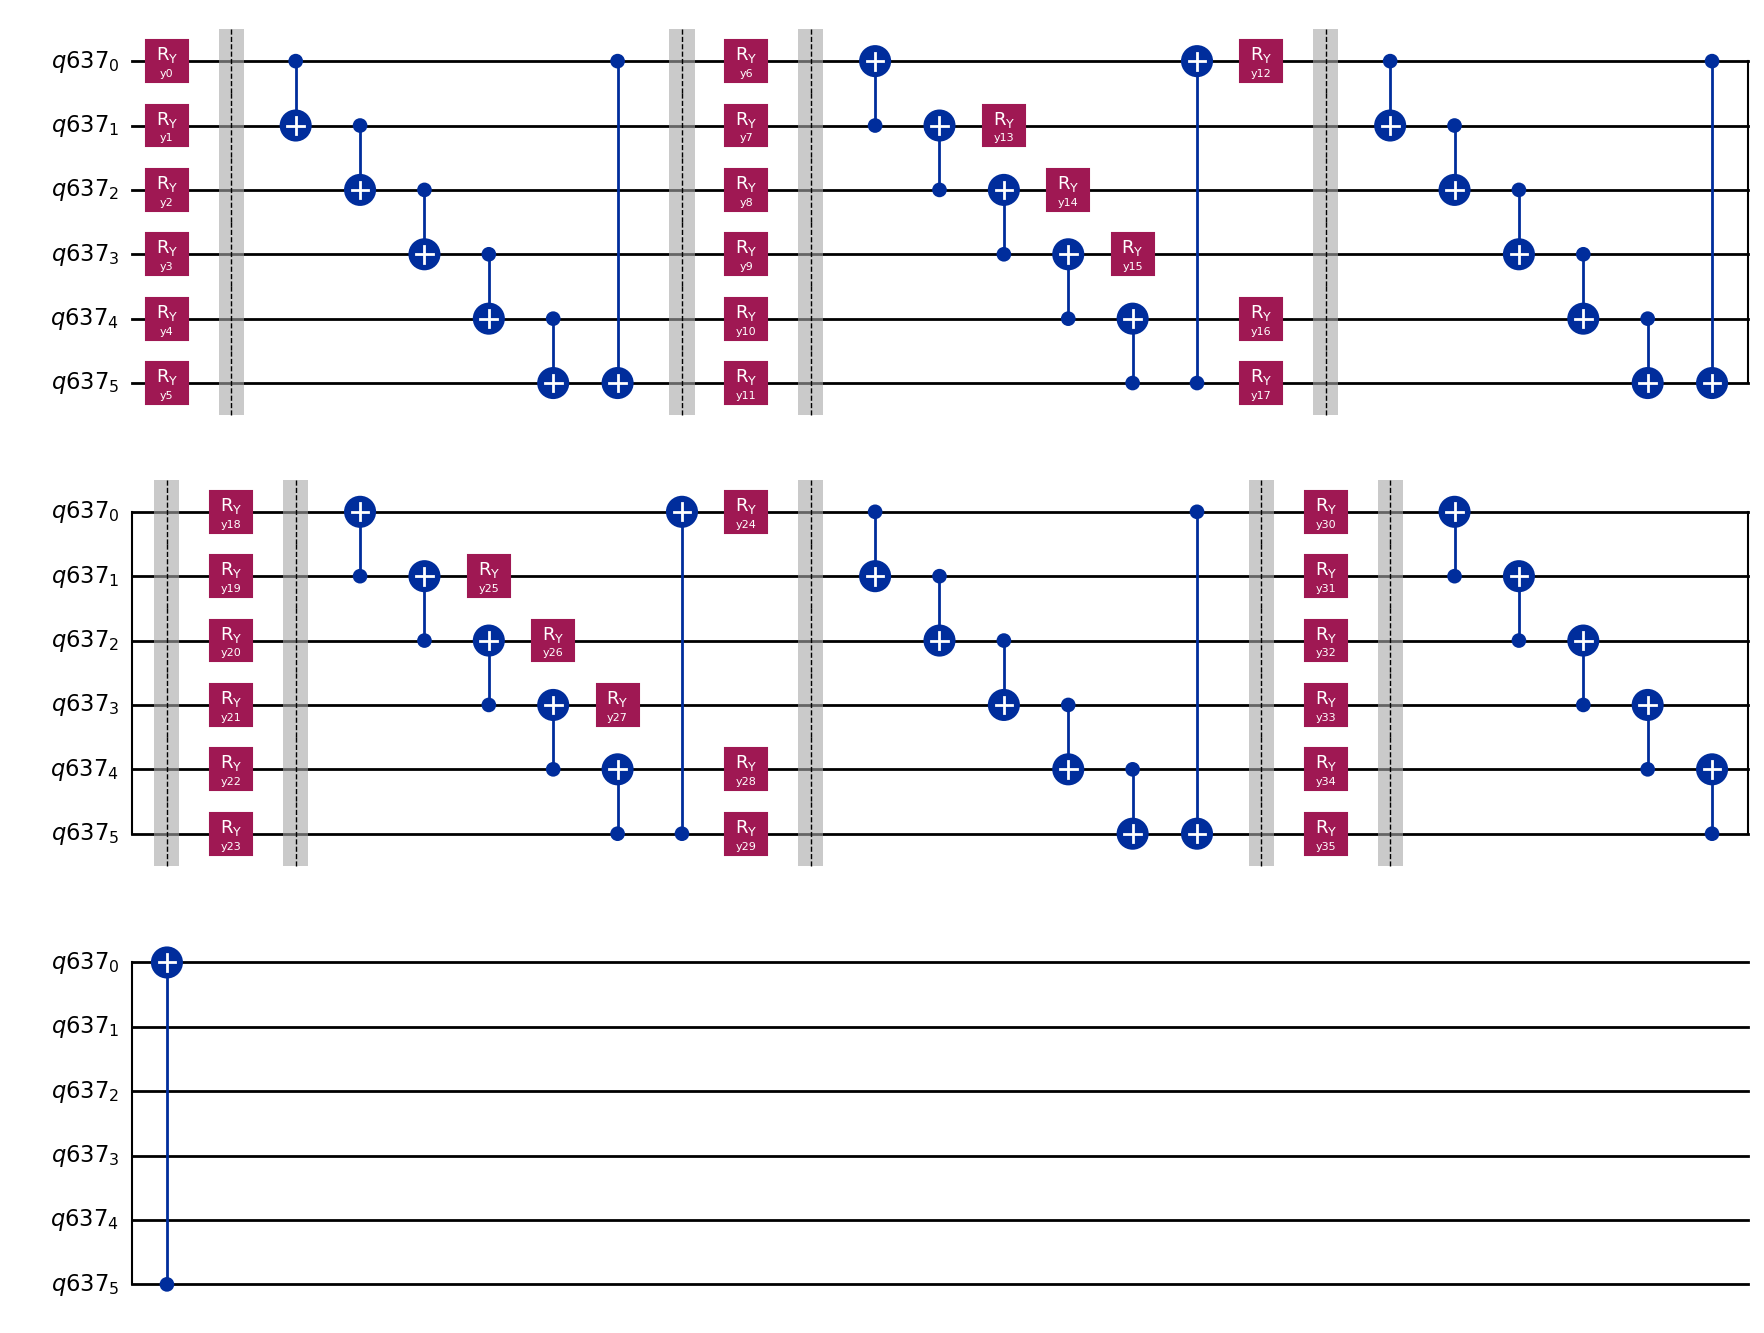

In [49]:
#fig = plt.figure()
ans.draw('mpl', style='iqx')
#plt.savefig(path_2_save+'tutorial'+'/ansatz.jpeg',dpi=800)
#plt.show()

In [106]:
parityyy = lambda x: "{:b}".format(x).count("1") % 2
qnn = CircuitQNN(circuit=model, input_params=fm.parameters, weight_params=ans.parameters, 
                  interpret=parityyy, output_shape=2, quantum_instance=qi)
initial_weights = (np.random.rand(qnn.num_weights) - 1)

In [107]:
type(qnn)

qiskit_machine_learning.neural_networks.circuit_qnn.CircuitQNN

In [108]:
def training(learning_rate, x_train, y_train, x_test, y_test, model2):
    ### Create the vectors that feed the QNN
    """
        Function that compute the training process.

        Parameters:
            (float) learning_rate : learning rate used by the optimizer;
            (np.ndarray) x_train : array of each train image sees by the model;
            (np.ndarray) y_train : array of train labels associated to each image;
            (np.ndarray) x_test : array of each test image sees by the model;
            (np.ndarray) y_test : array of test labels associated to each image;
            (qiskit_machine_learning object) model2 : Qiskit_machine_learning.neural_networks model to use for the process.
        
        Returns:
            (float) train_acc : accuracy during training;
            (float) test_acc : accuracy during test;
            (list) y01_digits : list of true train labels;
            (list) y_predict : list of predicted train labels;
            (list) y01_digits_test : list of true test labels;
            (list) y_predict_test : list of predicted test labels;
            (list) loss_values : list of loss values computed during the training;
            (list) accuracy_f: list of train accuracy values computed during the training.

    """
    x_digits = [x_train[i].flatten() for i in range(len(x_train))]
    y01_digits = [y_train[i] for i in range(len(y_train))]
    X_digits_test= [x_test[i].flatten() for i in range(len(x_test))]
    y01_digits_test= [y_test[i] for i in range(len(y_test))] 
    
    ## Set the optimizer and the loss
    #optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
    optimizer = LBFGS(model2.parameters(),lr=learning_rate)
    f_loss = CrossEntropyLoss()
    model2.train()
    accuracy_f = []
    loss_values = []

    def closure():  ### function we are going to pass to the model's train
        """
            Compute the loss function we are going to use within the process.

            Parameters:
                None
        
            Returns:
                (float) loss.
        """
        optimizer.zero_grad()
        loss = 0.0
        accuracy = 0.0
        for x, y_target in zip(x_digits, y01_digits): 
            output = model2(Tensor(x)).reshape(1, 2)
            loss += f_loss(output, Tensor([y_target]).long())
            correct_prediction = (output.argmax(dim=1) == y_target).item()
            accuracy += correct_prediction
            
        loss.backward()
        print("Train Loss:", loss.item())
        loss_values.append(loss.item())
        accuracy_f.append(accuracy/len(x_digits))
        print("Train accuray:", accuracy/len(x_digits))
        return loss
    
    optimizer.step(closure)
    optimizer.step(closure)
    print("Loss on training:", loss_values)
    print("Accuracy on training:", accuracy_f)

    
    ### Test evaluation on the Train set
    y_predict = []
    for x in x_digits:
        output = model2(Tensor(x))
        y_predict += [np.argmax(output.detach().numpy())]
 
    print("Predicted labels:", y_predict)
    train_acc = np.mean(y_predict == np.array(y01_digits))

    ### Test eveluation on the Test set
    y_predict_test = []
    for x in X_digits_test:
        output_test = model2(Tensor(x))
        y_predict_test += [np.argmax(output_test.detach().numpy())]
    test_acc = np.mean(y_predict_test == np.array(y01_digits_test))

    return train_acc, test_acc, y01_digits, y_predict, y01_digits_test, y_predict_test, loss_values, accuracy_f

In [109]:
model2 = TorchConnector(qnn, initial_weights) # call the model and connect with TorchConnector object
run = [0,1,2,3,4]

seed0 = 0
seed1 = 1
seed2 = 2
seed3 = 3
seed4 = 4
seedsss = [seed0,seed1,seed2,seed3,seed4] # we set 5 seeds because we are going to repeat the process 5 times
# with always different images for training. The test set instead is kept fixed.

# Set 2 accuracy arrays to store the results
values_train_acc = np.zeros(5) 
values_test_acc = np.zeros(5)

# make 2 dataframes where we collect the results
datatrain = {
    "run":[],
    "loss":[],
    "train_accuracy":[]
}

df = {
    "run":[],
    "train acc.":[],
    "test acc.":[],
    "ntrain":[],
    "ntest":[]
}

In [110]:
from data_generation import data_mnist

### Visualize some data - TEST SET

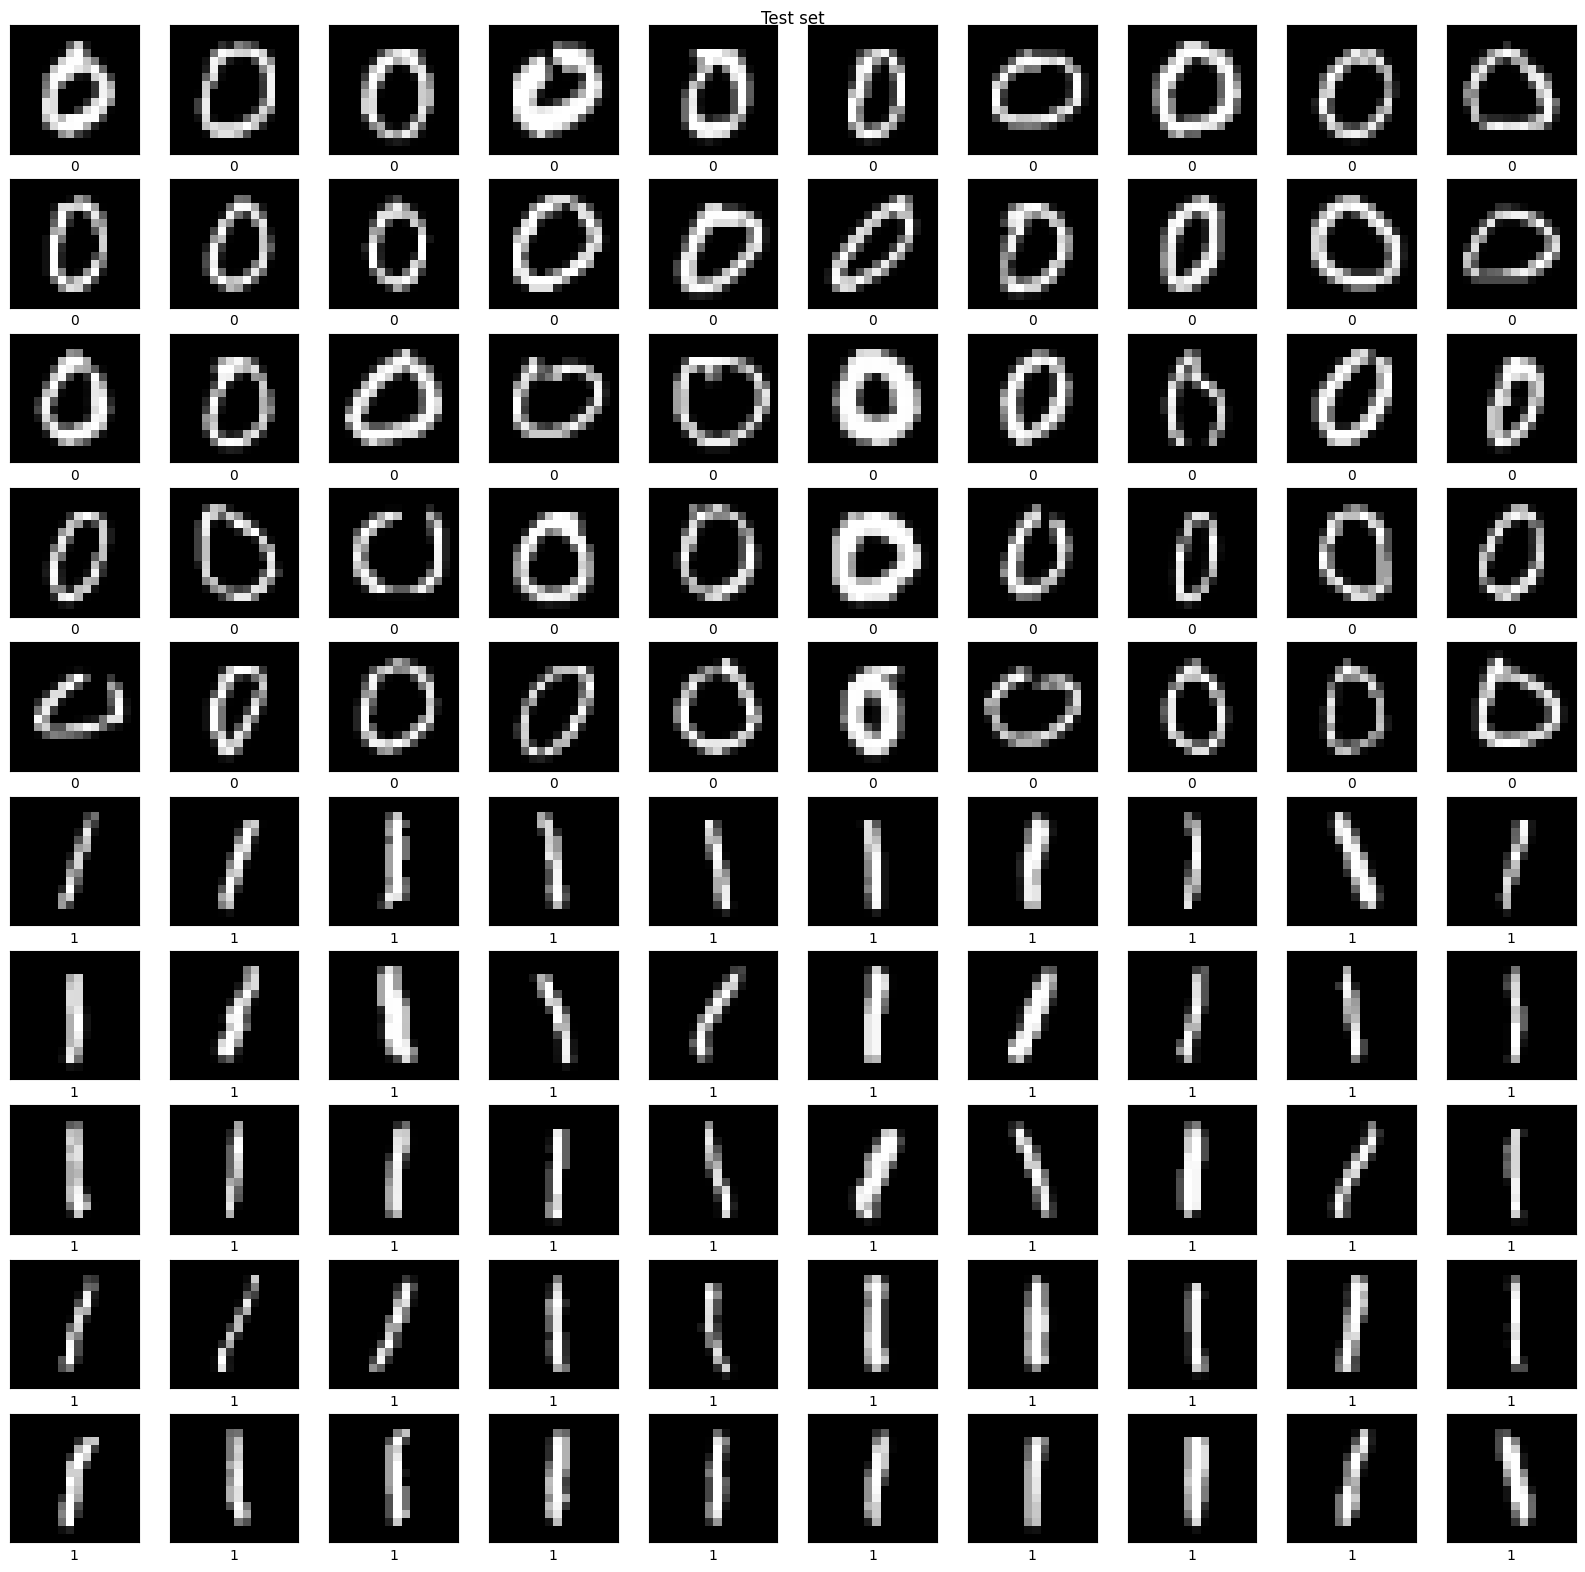

In [101]:
data = data_mnist(9)
x_train, y_train, x_test, y_test, n = data.data_creation(zerotrain=10, onetrain=10, nfeatures=16)

def test_plot_result(Xtest, Ypredicted):
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(16, 16))
    fig.suptitle("Test set")

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(Xtest[i].reshape((16,16)), cmap="gray")
        ax.set_xlabel(Ypredicted[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)

    #save = plt.savefig("/Users/francescoaldoventurelli/Desktop/TESI_FINAL/train/train"+str(num_train)+"_dist_run_WF_2L"+str(nrun+1)+".jpg")
    #plt.close()
    return fig

test_plot_result(x_test,y_test)
plt.show()

In [111]:
for nrun,j in zip(run,seedsss):
    
    print("Starting run number:", nrun+1)
    print("")

    data = data_mnist(myseed=seedsss[j])
    x_train, y_train, x_test, y_test, n = data.data_creation(zerotrain=10,onetrain=10,nfeatures=16)
    train_accuracy,test_accuracy, y01_train, y_predicted_train, y01_test, y_predicted_test,loss, tr_acc =training(0.07,
                                                                                                             x_train,
                                                                                                             y_train,
                                                                                                             x_test,
                                                                                                             y_test,
                                                                                                             model2)
    
    ### append values to dataframes
    datatrain['run'].append(nrun)
    datatrain['loss'].append(loss)
    datatrain['train_accuracy'].append(tr_acc)

    df['run'].append(nrun)
    df['train acc.'].append(train_accuracy)
    df['test acc.'].append(test_accuracy)
    df['ntrain'].append(n)
    df['ntest'].append(len(y_test))
    
    print("Train accuracy: ", train_accuracy)
    print("Test accuracy: ", test_accuracy)
    print("Num train images: ", n)

    cm_train = confusion_m_training(y01_train, y_predicted_train, n, nrun)
    cm_test = confusion_m_testing(y01_test, y_predicted_test, n, nrun)


Starting run number: 1

Train Loss: 13.969507217407227
Train accuray: 0.6
Train Loss: 14.217201232910156
Train accuray: 0.5
Train Loss: 13.817852973937988
Train accuray: 0.6
Train Loss: 14.085819244384766
Train accuray: 0.45
Train Loss: 13.72847843170166
Train accuray: 0.6
Train Loss: 13.204339981079102
Train accuray: 0.7
Train Loss: 12.965723991394043
Train accuray: 0.7
Train Loss: 13.015141487121582
Train accuray: 0.65
Train Loss: 12.815289497375488
Train accuray: 0.75
Train Loss: 12.680922508239746
Train accuray: 0.75
Train Loss: 12.665271759033203
Train accuray: 0.85
Train Loss: 12.611804962158203
Train accuray: 0.85
Train Loss: 12.769579887390137
Train accuray: 0.8
Train Loss: 12.577356338500977
Train accuray: 0.75
Train Loss: 12.681682586669922
Train accuray: 0.75
Train Loss: 12.779583930969238
Train accuray: 0.75
Train Loss: 12.638720512390137
Train accuray: 0.8
Train Loss: 12.404280662536621
Train accuray: 0.75
Train Loss: 12.393826484680176
Train accuray: 0.8
Train Loss: 12.13

In [112]:
datatrain = pd.DataFrame(datatrain)
datatrain

,run,loss,train_accuracy
0,0,"[13.969507217407227, 14.217201232910156, 13.81...","[0.6, 0.5, 0.6, 0.45, 0.6, 0.7, 0.7, 0.65, 0.7..."
1,1,"[12.667547225952148, 12.84223461151123, 12.694...","[0.6, 0.6, 0.65, 0.7, 0.75, 0.9, 0.8, 0.9, 0.8..."
2,2,"[12.116125106811523, 12.383323669433594, 12.04...","[0.85, 0.8, 0.9, 0.95, 0.9, 0.9, 0.9, 0.95, 0...."
3,3,"[11.741077423095703, 11.611388206481934, 11.56...","[0.75, 0.8, 0.8, 0.85, 0.9, 0.85, 0.9, 0.85, 0..."
4,4,"[12.307528495788574, 11.954216003417969, 12.03...","[0.8, 0.85, 0.85, 0.85, 0.9, 0.9, 0.85, 0.85, ..."


In [113]:
df

{'run': [0, 1, 2, 3, 4],
 'train acc.': [0.9, 1.0, 1.0, 0.95, 0.9],
 'test acc.': [0.67, 0.67, 0.75, 0.78, 0.76],
 'ntrain': [20, 20, 20, 20, 20],
 'ntest': [100, 100, 100, 100, 100]}

In [114]:
TestAcc_6imgs = np.array(df['test acc.'])
TestAcc_6imgs

TrainAcc_6imgs = np.array(df['train acc.'])

In [115]:
print("Train accuracy average:", round(np.mean(TrainAcc_6imgs),2), "std:", round(np.std(TrainAcc_6imgs),2))
print("Test accuracy average:", round(np.mean(TestAcc_6imgs),2), "std:", round(np.std(TestAcc_6imgs),2))

Train accuracy average: 0.95 std: 0.04
Test accuracy average: 0.73 std: 0.05


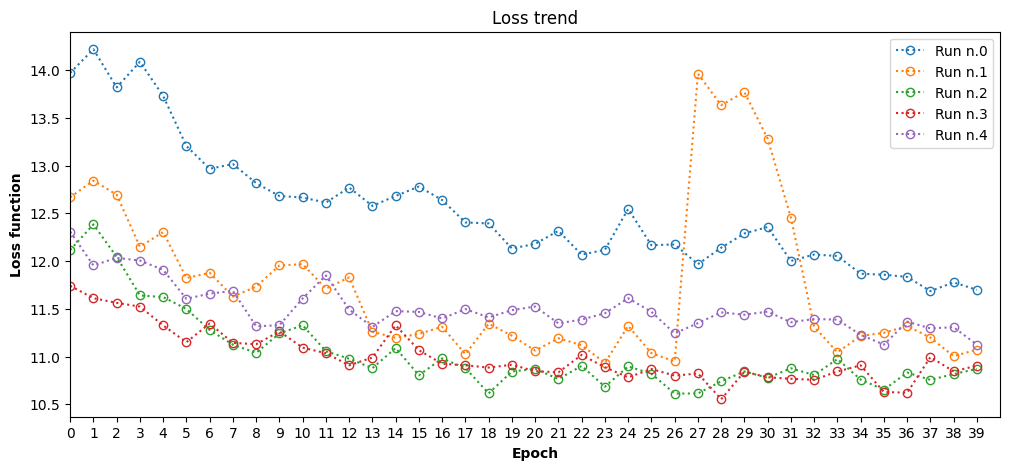

In [117]:
plt.figure(figsize=(12,5))
x = np.arange(0,40,1)
for i in range(5):
    plt.plot(datatrain['loss'].loc[i], label='Run n.'+str(i), marker='o', fillstyle='none', ls=':')
plt.xlabel("Epoch", fontweight='semibold')
plt.title("Loss trend")
plt.xlim(0,40)
plt.xticks(x)
plt.ylabel("Loss function", fontweight='semibold')
plt.legend(loc='best')
plt.savefig('/Users/francescoaldoventurelli/Desktop/tutorial/Loss.jpg', dpi=900)


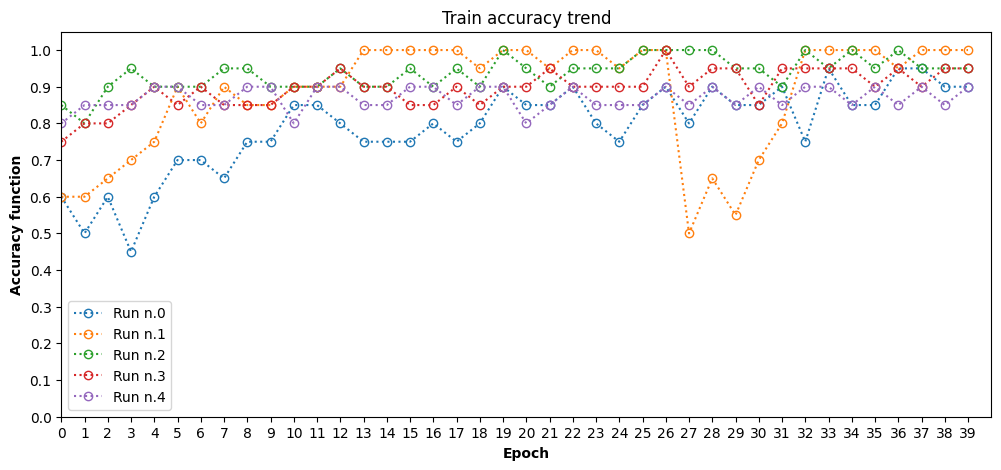

In [122]:
plt.figure(figsize=(12,5))
y = np.arange(0,1.1,0.1)
for i in range(5):
    plt.plot(datatrain['train_accuracy'].loc[i], label='Run n.'+str(i), marker='o', fillstyle='none', ls=':')
plt.xlabel("Epoch", fontweight='semibold')
plt.title("Train accuracy trend")
plt.xlim(0,40)
plt.ylim(0,1.05)
plt.xticks(x)
plt.yticks(y)
plt.ylabel("Accuracy function", fontweight='semibold')
plt.legend(loc='best')
plt.savefig('/Users/francescoaldoventurelli/Desktop/tutorial/train_Acc.jpg', dpi=900)

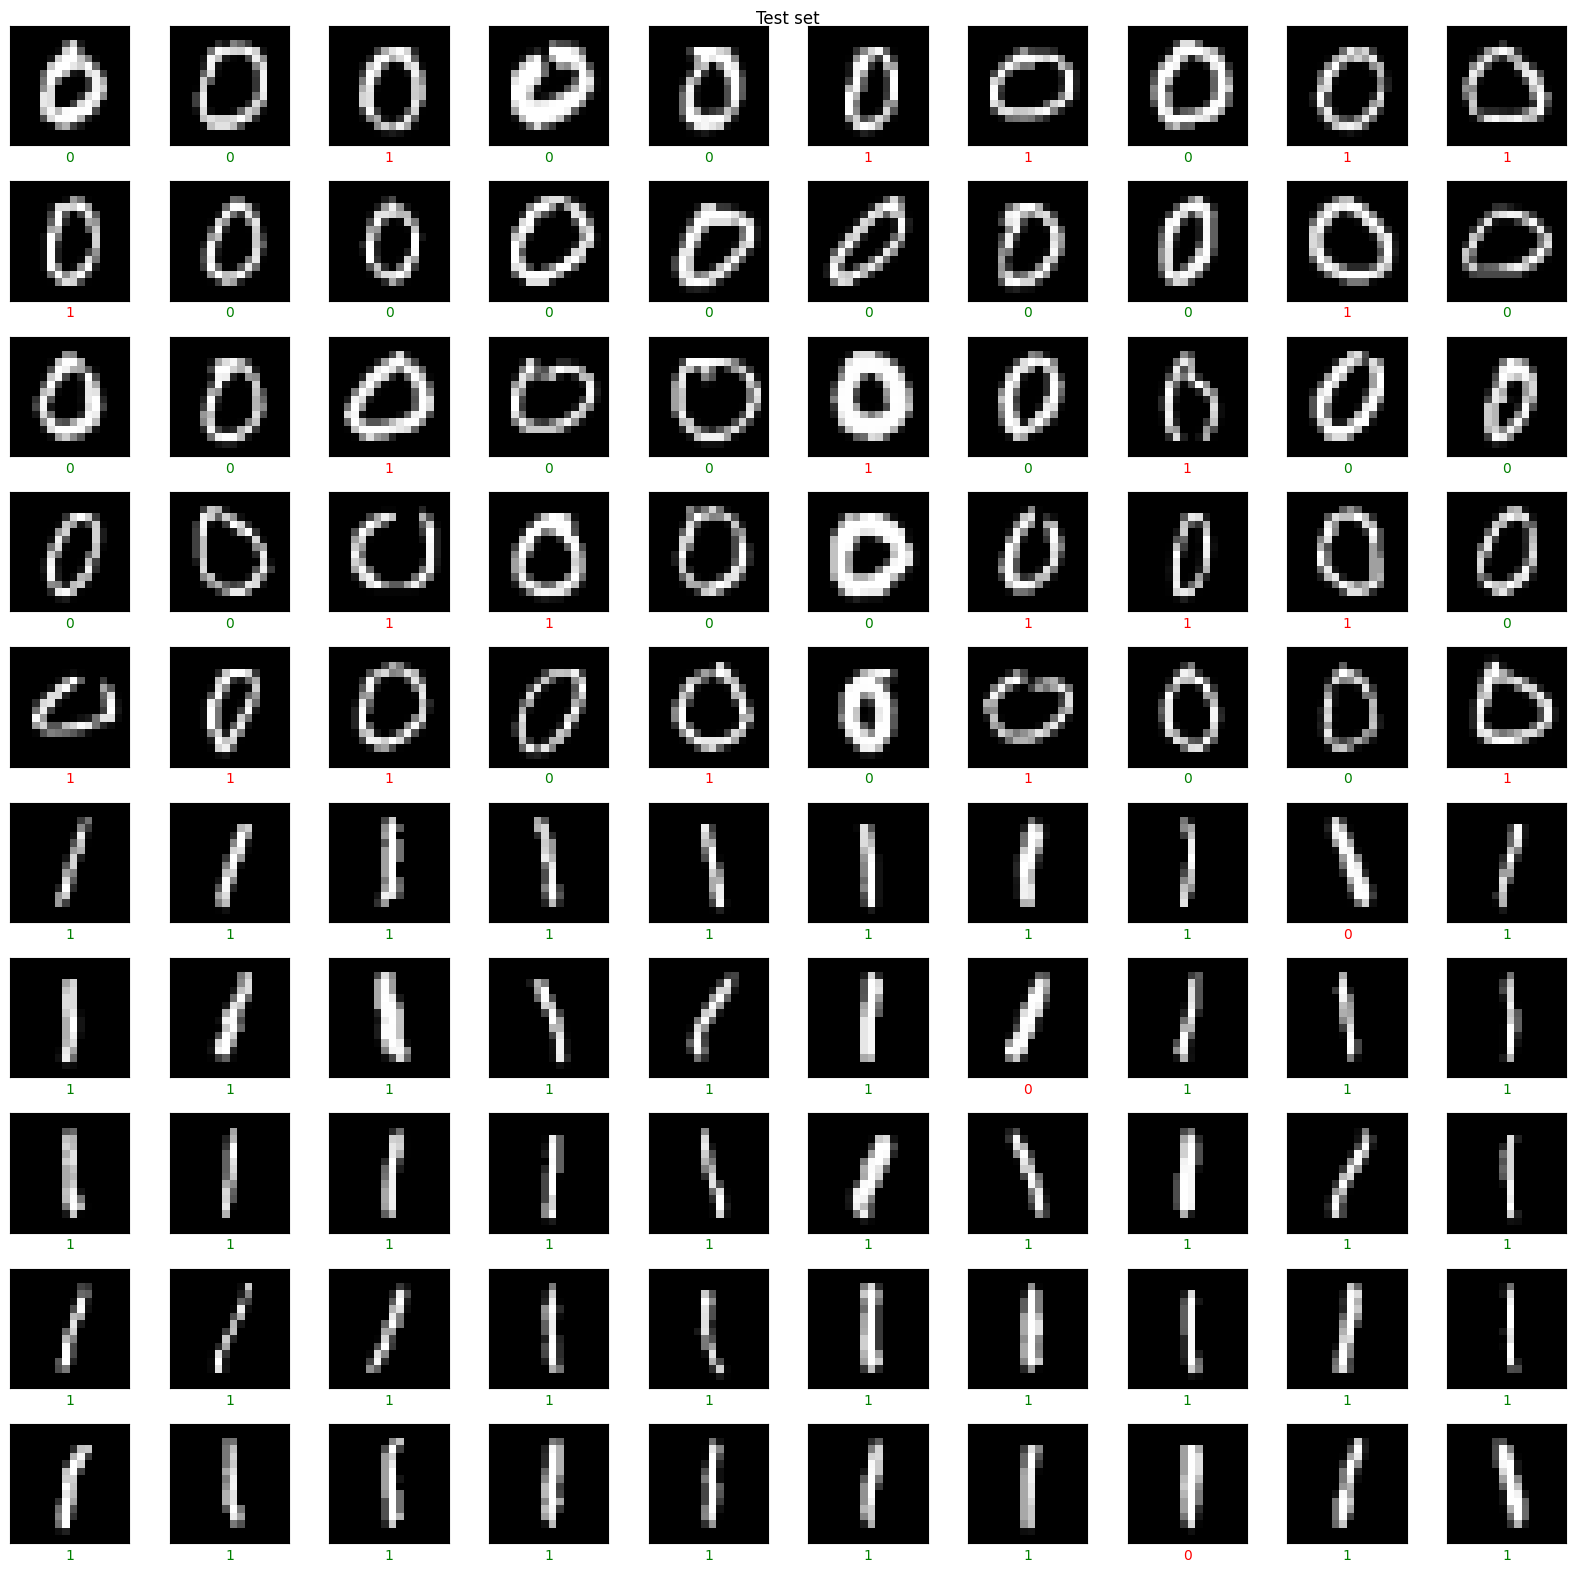

In [127]:
def test_plot_result_colored(Xtest, Ypredicted, Ytest):
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(16, 16))
    fig.suptitle("Test set")

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(Xtest[i].reshape((16,16)), cmap="gray")
        if Ytest[i] == Ypredicted[i]:
            ax.set_xlabel(Ypredicted[i]).set_color('green')
        else:
            ax.set_xlabel(Ypredicted[i]).set_color('red')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.3)

    #save = plt.savefig("/Users/francescoaldoventurelli/Desktop/TESI_FINAL/train/train"+str(num_train)+"_dist_run_WF_2L"+str(nrun+1)+".jpg")
    #plt.close()
    return fig

test_plot_result_colored(x_test,y_predicted_test,y01_test)
plt.show()